# Car plate inference

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import skimage.io as io
import cv2

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN"))  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CARPLATE_WEIGHTS_PATH = "mask_rcnn_carplate_0030.h5"  # TODO: update this path

d:\tool\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 车牌定位

In [2]:
config = carplate.CarplateConfig()
CARPLATE_DIR = os.path.join(ROOT_DIR, "dataset/carplate")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [5]:
# Load validation dataset
dataset = carplate.CarplateDataset()
dataset.load_carplate(CARPLATE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'carplate']


## Load Mask-RCNN Model

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [7]:
# Load weights
weights_path = CARPLATE_WEIGHTS_PATH
print("Loading weights", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights mask_rcnn_carplate_0030.h5


## Run Detection

image ID: carplate.粤BE24Q7.jpg (2) D:\project\simple-car-plate-recognition\dataset/carplate\val\粤BE24Q7.jpg


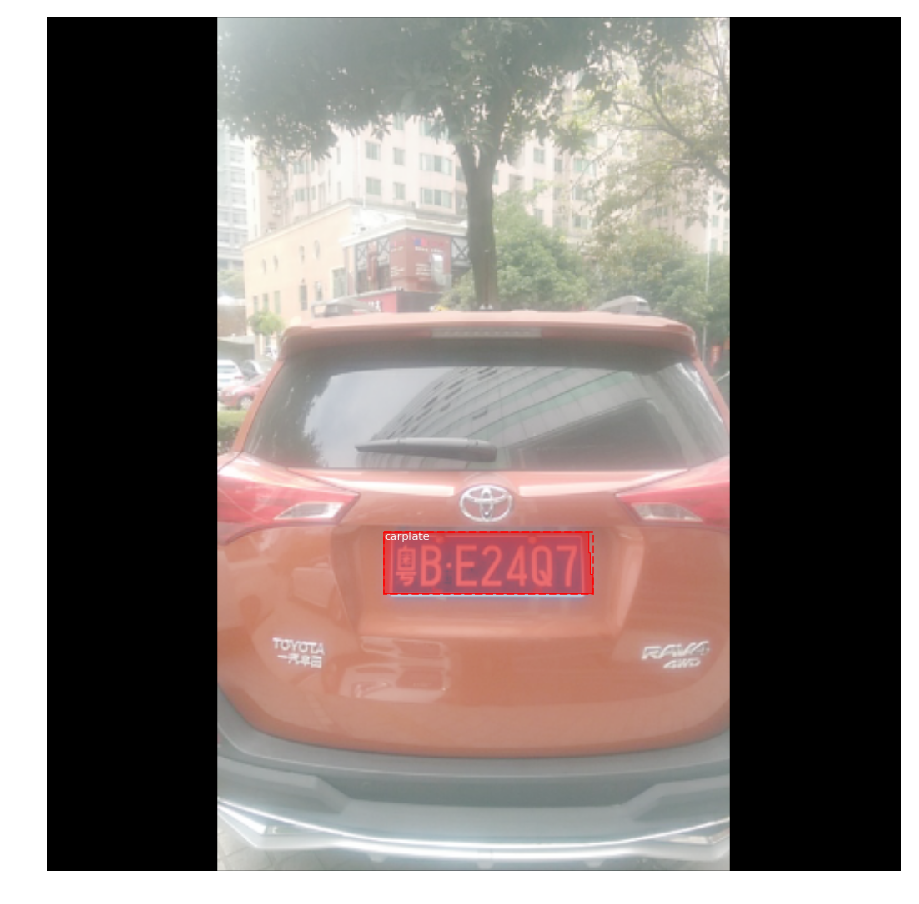

In [760]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


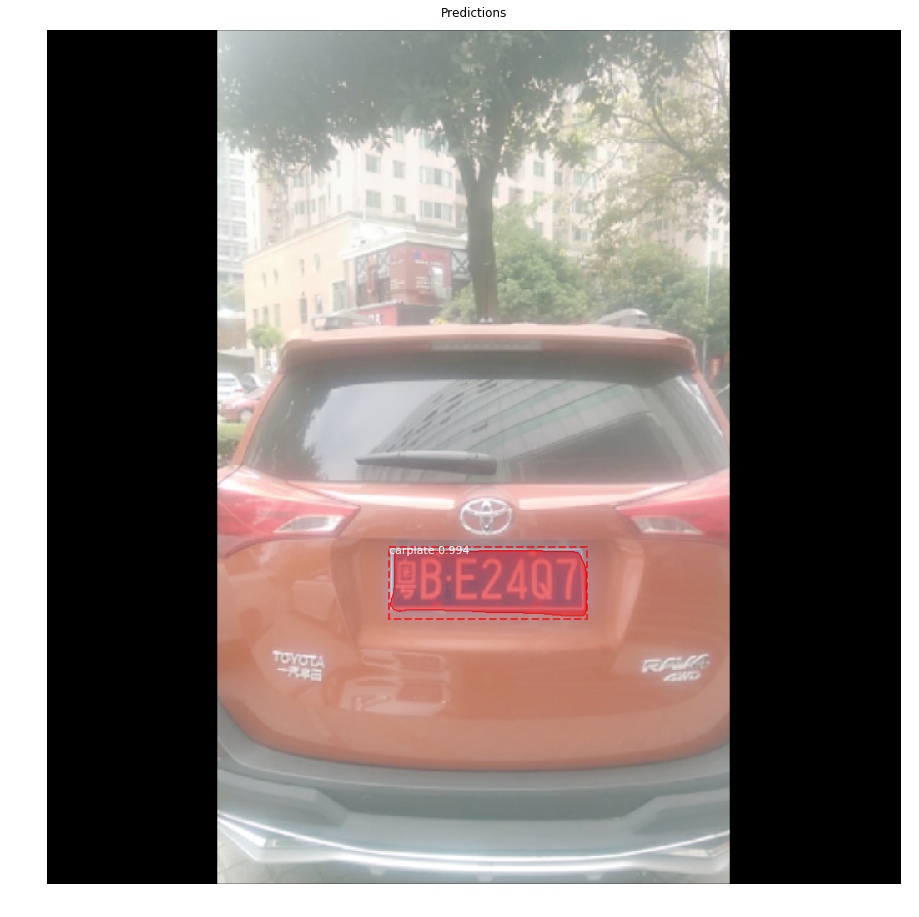

In [761]:
results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

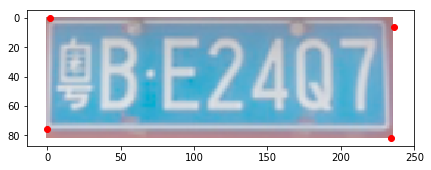

In [762]:
# 1.提取车牌区域，只取第一个车牌
mask = r['masks'][:,:,0].astype(np.uint8)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
cnt = contours[0]
epsilon = 0.1 * cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt, epsilon, True)
approx = approx.squeeze()

if approx.shape == (4,2):
    box = np.zeros_like(approx)
    box[:, 0] = approx[:, 1]
    box[:, 1] = approx[:, 0]
else:
    rect = cv2.minAreaRect(np.array(np.nonzero(mask)).T)
    box = cv2.boxPoints(rect).astype(np.int)

y0, x0 = box.min(axis=0)
y1, x1 = box.max(axis=0)
img = image[y0:y1, x0:x1]
io.imshow(img)

box[:, 0] -= y0
box[:, 1] -= x0

# 调整box顺序，从左上角开始，逆时针转动
i0 = (box[:,0]+box[:,1]).argmin()
box = box[[i0,(i0+1)%4,(i0+2)%4,(i0+3)%4]]

plt.scatter(box[:, 1], box[:, 0], c='r')

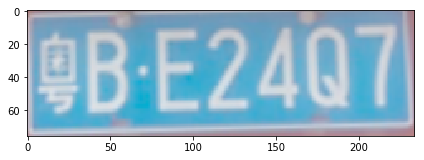

In [763]:
# 2.矫正车牌
h = np.max([box[1][0] - box[0][0], box[2][0] - box[3][0]])
w = np.max([box[2][1] - box[1][1], box[3][1] - box[0][1]])
box2 = np.array([(0, 0), (h, 0), (h, w), (0, w)])
M = cv2.getPerspectiveTransform(box[:,::-1].astype(np.float32), box2[:,::-1].astype(np.float32))
img = cv2.warpPerspective(img, M, (w, h))
img = cv2.resize(img, (220, 70))

io.imshow(img)

## 下面部分已弃用，字符识别新方法见：https://github.com/airxiechao/simple-car-plate-recognition-2

# 字符分割

In [764]:
import skimage.io as io
import skimage.color as color
import skimage.morphology as morphology
import skimage.feature as feature
import skimage.measure as measure
import skimage.transform as transform
import numpy as np
import math

from matplotlib import pyplot as plt
%matplotlib inline

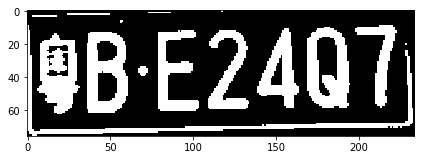

In [765]:
# 1. 转换为灰度图像
img2 = color.rgb2gray(img)
ret,img3 = cv2.threshold(img2,img2.max()*.8,1,cv2.THRESH_BINARY)
io.imshow(img3)

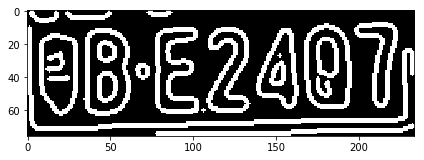

In [788]:
# 2. Canny边缘检测并膨胀
img4 = feature.canny(img3, sigma=3)
img4 = morphology.dilation(img4)
io.imshow(img4)

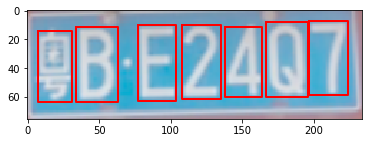

In [789]:
# 3. 标记并筛选区域
label_img = measure.label(img4)
regions = measure.regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

def in_bboxes(bbox, bboxes):
    for bb in bboxes:
        minr0, minc0, maxr0, maxc0 = bb
        minr1, minc1, maxr1, maxc1 = bbox
        if minr1 >= minr0 and maxr1 <= maxr0 and minc1 >= minc0 and maxc1 <= maxc0:
            return True
    return False

bboxes = []
for props in regions:
    y0, x0 = props.centroid
    minr, minc, maxr, maxc = props.bbox
    
    if maxc - minc > img4.shape[1] / 7 or maxr - minr < img4.shape[0] / 3:
        continue
        
    bbox = [minr, minc, maxr, maxc]
    if in_bboxes(bbox, bboxes):
        continue
        
    if abs(y0 - img4.shape[0] / 2) > img4.shape[0] / 4:
        continue
        
    bboxes.append(bbox)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2)

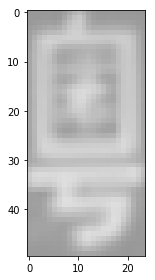

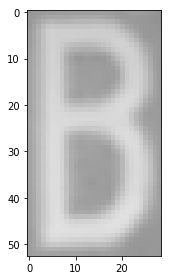

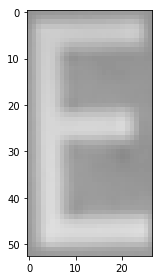

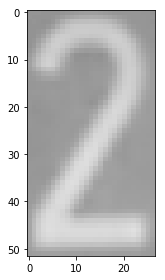

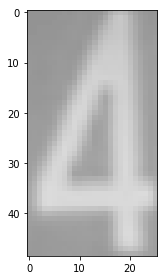

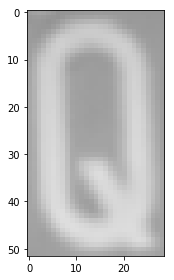

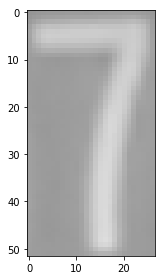

In [790]:
# 4. 提取单个字符图像
bboxes = sorted(bboxes, key=lambda x: x[1])
chars = []
for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    ch = img2[minr:maxr, minc:maxc]
    chars.append(ch)
    io.imshow(ch)
    plt.show()

# 字符识别

In [791]:
DATASET_DIR = 'dataset/carplate'
classes = os.listdir(DATASET_DIR + "/ann/")

num_classes = len(classes)
img_rows, img_cols = 20, 20

if K.image_data_format() == 'channels_first':
    input_shape = [1, img_rows, img_cols]
else:
    input_shape = [img_rows, img_cols, 1]

In [792]:
model_char = Sequential()
model_char.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_char.add(Conv2D(64, (3, 3), activation='relu'))
model_char.add(MaxPooling2D(pool_size=(2, 2)))
model_char.add(Dropout(0.25))
model_char.add(Flatten())
model_char.add(Dense(128, activation='relu'))
model_char.add(Dropout(0.5))
model_char.add(Dense(num_classes, activation='softmax'))

model_char.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [793]:
model_char.load_weights("char_cnn/char_cnn.h5")

In [794]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

In [795]:
chars2 = []
for ch in chars:
    chars2.append(transform.resize(ch, [img_rows, img_cols]))
    
chars2 = np.stack(chars2)

In [796]:
ys = np.unique(classes)

p_test = model_char.predict_classes(extend_channel(chars2))
print(' '.join([ys[p_test[i]] for i in range(len(p_test))]))

zh_yue B E 2 4 Q T
